In [1]:
import numpy as np
import os
#import pkgconfig
#pkgconfig.parse('/scratch/network/sejk/envs/fenicsscratch/lib/pkgconfig/dolfin.pc')

from fenics import *
import matplotlib.pyplot as plt
import time


# DEFAULT

Fri Mar 29 11:44:58 2024

burgers_time_viscous_test:
  FENICS/Python version
  Solve the time-dependent 1d viscous Burgers equation.

  Number of elements is 256
  Viscosity set to 0.0031831
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.

Reached final time.
(101,)
(256,)
(256, 101)

burgers_time_viscous_test:
  Normal end of execution.

Fri Mar 29 11:45:10 2024
elapsed time: 11.59299635887146


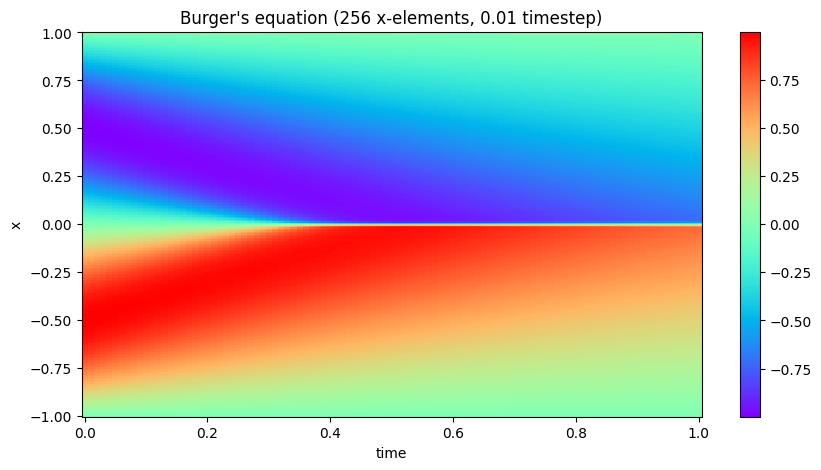

In [2]:
# DEFAULT
def burgers_time_viscous ( e_num, nu, dt ):

#*****************************************************************************80
#
#
#    dudt - nu u" + u del u = 0,
#    -1 < x < 1, 0 < t
#    u(-1,t) = -1, u(1,t) = 1 => 0
#    u(x,0) = x => -sin(pix)
#
#
  import matplotlib.pyplot as plt

  print ( '' )
  print ( '  Number of elements is %d' % ( e_num ) )
  print ( '  Viscosity set to %g' % ( nu ) )
#
#  Create a mesh on the interval [-1,+1].
#
  x_left = -1.0
  x_right = +1.0
  mesh = IntervalMesh ( e_num, x_left, x_right )
#
#  Define the function space to be of Lagrange type
#  using piecewise linear basis functions.
#
  V = FunctionSpace ( mesh, "CG", 1 )
#
#  Define the boundary conditions.
#  if X <= XLEFT + eps, then U = U_LEFT
#  if X_RIGHT - eps <= X, then U = U_RIGHT
#
  u_left = 0.0 #-1.0
  def on_left ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_left ) )
  bc_left = DirichletBC ( V, u_left, on_left )

  u_right = 0.0 #+1.0
  def on_right ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_right ) )
  bc_right = DirichletBC ( V, u_right, on_right )

  bc = [ bc_left, bc_right ]
#
#  Define the initial condition.
#
  u_init = Expression ( "-sin(pi*x[0])", degree = 1 ) # x[0]
#
#  Define the trial functions (u) and test functions (v).
#
  u = Function ( V )
  u_old = Function ( V )
  v = TestFunction ( V )
#
#  Set U and U0 by interpolation.
#
  u.interpolate ( u_init )
  u_old.assign ( u )
#
#  Set the time step.
#  We need a UFL version "DT" for the function F,
#  and a Python version "dt" to do a conditional in the time loop.
#
  DT = Constant ( dt )#0.01 )
  #dt = 0.01
#
#  Set the source term.
#
  f = Expression ( "0.0", degree = 0 )
#
#  Write the function to be satisfied.
#
  n = FacetNormal ( mesh )
#
#  Write the function F.
#
  F = \
  ( \
    dot ( u - u_old, v ) / DT \
  + nu * inner ( grad ( u ), grad ( v ) ) \
  + inner ( u * u.dx(0), v ) \
  - dot ( f, v ) \
  ) * dx
#
#  Specify the jacobian.
#
  J = derivative ( F, u )
#
#  Do the time integration.
#
  k = 0
  t = 0.0

  t_plot = 0.0
  t_final = 1.0

  ### mine ###
  x_list = np.linspace(-1.0,1.0,256) # 256 elements in x
  x_all = []
  #t_list = np.linspace(0.0,1.0,100)
  #print(u(1))
  ############

  while ( True ):

    if ( k % 1 == 0 ): # 100
      plot ( u, title = ( 'burgers time viscous %g' % ( t ) ) )

      ######################
      arr = []
      for i in x_list:
        arr.append(u(i))
      x_all.append(arr)
      #####################

      plt.grid ( True )
      #filename = ( 'burgers_time_viscous_%d.png' % ( k ) )
      #plt.savefig ( filename )
      #print ( 'Graphics saved as "%s"' % ( filename ) )
      plt.close ( )
      t_plot = t_plot + 0.1

    if ( t_final <= t ):
      print ( '' )
      print ( 'Reached final time.' )
      break

    k = k + 1
    t = t + dt

    solve ( F == 0, u, bc, J = J )

    u_old.assign ( u )

  return x_all

def burgers_time_viscous_test ( ):

#*****************************************************************************80
#
## burgers_time_viscous_test tests burgers_time_viscous.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    21 October 2018
#
#  Author:
#
#    John Burkardt
#

  print ( time.ctime ( time.time() ) )
#
#  Report level = only warnings or higher.
#
  level = 30
  set_log_level ( level )

  print ( '' )
  print ( 'burgers_time_viscous_test:' )
  print ( '  FENICS/Python version' )
  print ( '  Solve the time-dependent 1d viscous Burgers equation.' )

  e_num = 256 # for 256 elements in [-1,1]
  dt = 0.01 #
  nu = 0.01 / np.pi
  x_all = burgers_time_viscous ( e_num, nu ,dt)
  x_all = np.array(x_all)

####

  x_list = np.linspace(-1.0,1.0,256)
  times = np.linspace(0,1,int(1/dt) + 1) # timesteps
  plt.subplots(figsize=(10,5))
  c = plt.pcolormesh(times, x_list, x_all.T,cmap='rainbow')
  plt.colorbar(c)
  plt.xlabel('time')
  plt.ylabel('x')
  plt.title(f"Burger's equation ({e_num} x-elements, {dt} timestep)")

  print(times.shape)
  print(x_list.shape)
  print(x_all.T.shape)


###

#
#  Terminate.
#
  print ( "" )
  print ( "burgers_time_viscous_test:" )
  print ( "  Normal end of execution." )
  print ( '' )
  print ( time.ctime ( time.time() ) )
  return x_list, times, x_all

if ( __name__ == '__main__' ):
    start = time.time()
    data = burgers_time_viscous_test ( )
    end = time.time()
    print("elapsed time:", end - start)

# CAN CHANGE E_NUM

Wed Mar 13 22:30:25 2024

burgers_time_viscous_test:
  FENICS/Python version
  Solve the time-dependent 1d viscous Burgers equation.

  Number of elements is 25600
  Viscosity set to 0.0031831

Reached final time.
(101,)
(25600,)
(25600, 101)

burgers_time_viscous_test:
  Normal end of execution.

Wed Mar 13 22:30:49 2024
elapsed time: 23.537277936935425


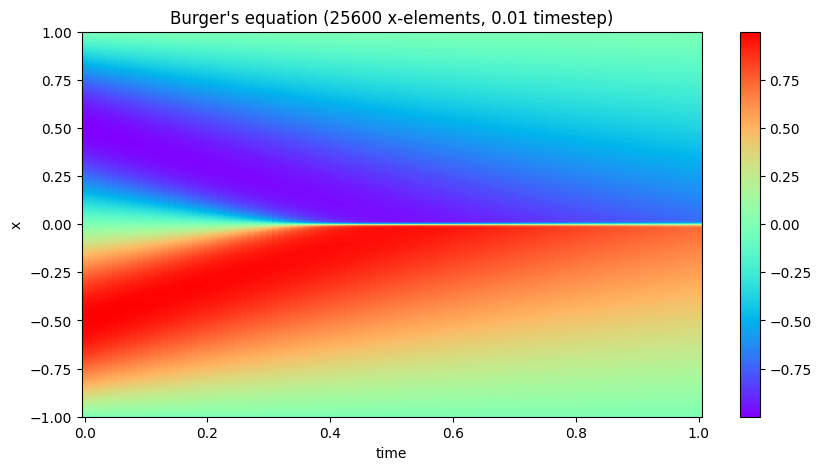

In [6]:
# changing e_num works

def burgers_time_viscous ( e_num, nu, dt ):

#*****************************************************************************80
#
#
#    dudt - nu u" + u del u = 0,
#    -1 < x < 1, 0 < t
#    u(-1,t) = -1, u(1,t) = 1 => 0
#    u(x,0) = x => -sin(pix)
#
#

  print ( '' )
  print ( '  Number of elements is %d' % ( e_num ) )
  print ( '  Viscosity set to %g' % ( nu ) )
#
#  Create a mesh on the interval [-1,+1].
#
  x_left = -1.0
  x_right = +1.0
  mesh = IntervalMesh ( e_num, x_left, x_right )
#
#  Define the function space to be of Lagrange type
#  using piecewise linear basis functions.
#
  V = FunctionSpace ( mesh, "CG", 1 )
#
#  Define the boundary conditions.
#  if X <= XLEFT + eps, then U = U_LEFT
#  if X_RIGHT - eps <= X, then U = U_RIGHT
#
  u_left = 0.0 #-1.0
  def on_left ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_left ) )
  bc_left = DirichletBC ( V, u_left, on_left )

  u_right = 0.0 #+1.0
  def on_right ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_right ) )
  bc_right = DirichletBC ( V, u_right, on_right )

  bc = [ bc_left, bc_right ]
#
#  Define the initial condition.
#
  u_init = Expression ( "-sin(pi*x[0])", degree = 1 ) # x[0]
#
#  Define the trial functions (u) and test functions (v).
#
  u = Function ( V )
  u_old = Function ( V )
  v = TestFunction ( V )
#
#  Set U and U0 by interpolation.
#
  u.interpolate ( u_init )
  u_old.assign ( u )
#
#  Set the time step.
#  We need a UFL version "DT" for the function F,
#  and a Python version "dt" to do a conditional in the time loop.
#
  DT = Constant ( dt )#0.01 )
  #dt = 0.01
#
#  Set the source term.
#
  f = Expression ( "0.0", degree = 0 )
#
#  Write the function to be satisfied.
#
  n = FacetNormal ( mesh )
#
#  Write the function F.
#
  F = \
  ( \
    dot ( u - u_old, v ) / DT \
  + nu * inner ( grad ( u ), grad ( v ) ) \
  + inner ( u * u.dx(0), v ) \
  - dot ( f, v ) \
  ) * dx
#
#  Specify the jacobian.
#
  J = derivative ( F, u )
#
#  Do the time integration.
#
  k = 0
  t = 0.0

  t_plot = 0.0
  t_final = 1.0

  ### mine ###
  x_list = np.linspace(-1.0,1.0,e_num) # 256 elements in x
  x_all = []
  #t_list = np.linspace(0.0,1.0,100)
  #print(u(1))
  ############

  while ( True ):

    if ( k % 1 == 0 ): # 1: runs 1 / dt times 
      plot ( u, title = ( 'burgers time viscous %g' % ( t ) ) )

      ######################
      arr = []
      for i in x_list:
        arr.append(u(i))
      x_all.append(arr)
      #####################

      plt.grid ( True )
      #filename = ( 'burgers_time_viscous_%d.png' % ( k ) )
      #plt.savefig ( filename )
      #print ( 'Graphics saved as "%s"' % ( filename ) )
      plt.close ( )
      t_plot = t_plot + 0.1

    if ( t_final <= t ):
      print ( '' )
      print ( 'Reached final time.' )
      break

    k = k + 1
    t = t + dt

    solve ( F == 0, u, bc, J = J )

    u_old.assign ( u )

  return x_all

def burgers_time_viscous_test ( ):

#*****************************************************************************80
#
## burgers_time_viscous_test tests burgers_time_viscous.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    21 October 2018
#
#  Author:
#
#    John Burkardt
#

  print ( time.ctime ( time.time() ) )
#
#  Report level = only warnings or higher.
#
  level = 30
  set_log_level ( level )

  print ( '' )
  print ( 'burgers_time_viscous_test:' )
  print ( '  FENICS/Python version' )
  print ( '  Solve the time-dependent 1d viscous Burgers equation.' )

  e_num = 25600 # for 25600 elements in [-1,1]
  dt = 0.01 #
  nu = 0.01 / np.pi
  x_all = burgers_time_viscous ( e_num, nu ,dt)
  x_all = np.array(x_all)

####

  x_list = np.linspace(-1.0,1.0,e_num)
  times = np.linspace(0,1,int(1/dt) + 1) # timesteps
  plt.subplots(figsize=(10,5))
  c = plt.pcolormesh(times, x_list, x_all.T,cmap='rainbow')
  plt.colorbar(c)
  plt.xlabel('time')
  plt.ylabel('x')
  plt.title(f"Burger's equation ({e_num} x-elements, {dt} timestep)")

  print(times.shape)
  print(x_list.shape)
  print(x_all.T.shape)


###

#
#  Terminate.
#
  print ( "" )
  print ( "burgers_time_viscous_test:" )
  print ( "  Normal end of execution." )
  print ( '' )
  print ( time.ctime ( time.time() ) )
  return x_list, times, x_all

if ( __name__ == '__main__' ):
    start = time.time()
    data = burgers_time_viscous_test ( )
    end = time.time()
    print("elapsed time:", end - start)

# CAN CHANGE E_NUM, dt

Wed Apr 10 16:46:52 2024

burgers_time_viscous_test:
  FENICS/Python version
  Solve the time-dependent 1d viscous Burgers equation.

  Number of elements is 2049
  Viscosity set to 0.0031831

Reached final time.
elapsed time: 1.5952675342559814
(101,)
(2049,)
(2049, 101)

burgers_time_viscous_test:
  Normal end of execution.

Wed Apr 10 16:46:54 2024


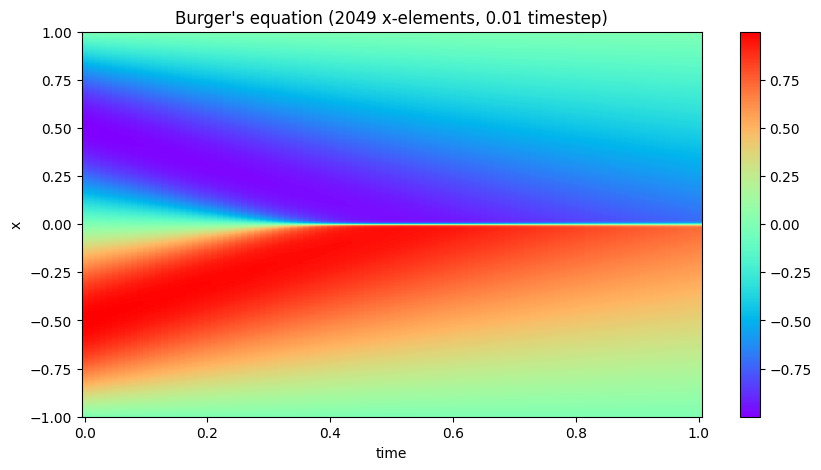

In [2]:
# changing e_num works

def burgers_time_viscous ( e_num, nu, dt ):

#*****************************************************************************80
#
#
#    dudt - nu u" + u del u = 0,
#    -1 < x < 1, 0 < t
#    u(-1,t) = -1, u(1,t) = 1 => 0
#    u(x,0) = x => -sin(pix)
#
#

  print ( '' )
  print ( '  Number of elements is %d' % ( e_num ) )
  print ( '  Viscosity set to %g' % ( nu ) )
#
#  Create a mesh on the interval [-1,+1].
#
  x_left = -1.0
  x_right = +1.0
  mesh = IntervalMesh ( e_num, x_left, x_right )
#
#  Define the function space to be of Lagrange type
#  using piecewise linear basis functions.
#
  V = FunctionSpace ( mesh, "CG", 1 )
#
#  Define the boundary conditions.
#  if X <= XLEFT + eps, then U = U_LEFT
#  if X_RIGHT - eps <= X, then U = U_RIGHT
#
  u_left = 0.0 #-1.0
  def on_left ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_left ) )
  bc_left = DirichletBC ( V, u_left, on_left )

  u_right = 0.0 #+1.0
  def on_right ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_right ) )
  bc_right = DirichletBC ( V, u_right, on_right )

  bc = [ bc_left, bc_right ]
#
#  Define the initial condition.
#
  u_init = Expression ( "-sin(pi*x[0])", degree = 1 ) # x[0]
#
#  Define the trial functions (u) and test functions (v).
#
  u = Function ( V )
  u_old = Function ( V )
  v = TestFunction ( V )
#
#  Set U and U0 by interpolation.
#
  u.interpolate ( u_init )
  u_old.assign ( u )
#
#  Set the time step.
#  We need a UFL version "DT" for the function F,
#  and a Python version "dt" to do a conditional in the time loop.
#
  DT = Constant ( dt )#0.01 )
  #dt = 0.01
#
#  Set the source term.
#
  f = Expression ( "0.0", degree = 0 )
#
#  Write the function to be satisfied.
#
  n = FacetNormal ( mesh )
#
#  Write the function F.
#
  F = \
  ( \
    dot ( u - u_old, v ) / DT \
  + nu * inner ( grad ( u ), grad ( v ) ) \
  + inner ( u * u.dx(0), v ) \
  - dot ( f, v ) \
  ) * dx
#
#  Specify the jacobian.
#
  J = derivative ( F, u )
#
#  Do the time integration.
#
  k = 0
  t = 0.0

  t_plot = 0.0
  t_final = 1.0

  ### mine ###
  x_list = np.linspace(-1.0,1.0,e_num) # 256 elements in x
  x_all = []
  #t_list = np.linspace(0.0,1.0,100)
  #print(u(1))
  ############

  while ( True ):

    if ( k % 1 == 0 ): # 1: runs 1 / dt times 
      #plot ( u, title = ( 'burgers time viscous %g' % ( t ) ) )

      ######################
      arr = []
      for i in x_list:
        arr.append(u(i))
      x_all.append(arr)
      #####################

      #plt.grid ( True )
      #filename = ( 'burgers_time_viscous_%d.png' % ( k ) )
      #plt.savefig ( filename )
      #print ( 'Graphics saved as "%s"' % ( filename ) )
      #plt.close ( )
      #t_plot = t_plot + 0.1

    if ( t_final <= t ):
      print ( '' )
      print ( 'Reached final time.' )
      break

    k = k + 1
    t = t + dt

    solve ( F == 0, u, bc, J = J )

    u_old.assign ( u )

  return x_all

def burgers_time_viscous_test ( ):

#*****************************************************************************80
#
## burgers_time_viscous_test tests burgers_time_viscous.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    21 October 2018
#
#  Author:
#
#    John Burkardt
#

  print ( time.ctime ( time.time() ) )
#
#  Report level = only warnings or higher.
#
  level = 30
  set_log_level ( level )

  print ( '' )
  print ( 'burgers_time_viscous_test:' )
  print ( '  FENICS/Python version' )
  print ( '  Solve the time-dependent 1d viscous Burgers equation.' )

  e_num =2048 + 1# for 25600 elements in [-1,1]
  dt = 0.01 #
  nu = 0.01 / np.pi

  start = time.time() # TIMING
  x_all = burgers_time_viscous ( e_num, nu ,dt)
  end = time.time()
  print("elapsed time:", end - start)
  
  x_all = np.array(x_all)

####

  x_list = np.linspace(-1.0,1.0,e_num)
  times = np.linspace(0,1,int(1/dt) + 1) # timesteps
  plt.subplots(figsize=(10,5))
  c = plt.pcolormesh(times, x_list, x_all.T,cmap='rainbow')
  plt.colorbar(c)
  plt.xlabel('time')
  plt.ylabel('x')
  plt.title(f"Burger's equation ({e_num} x-elements, {dt} timestep)")


  np.savetxt(f'./out/times_{e_num}_{dt}.out',times)
  np.savetxt(f'./out/x_list_{e_num}_{dt}.out',x_list)
  np.savetxt(f'./out/x_all_{e_num}_{dt}.out',x_all.T)
  print(times.shape)
  print(x_list.shape)
  print(x_all.T.shape)


###

#
#  Terminate.
#
  print ( "" )
  print ( "burgers_time_viscous_test:" )
  print ( "  Normal end of execution." )
  print ( '' )
  print ( time.ctime ( time.time() ) )
  return x_list, times, x_all

if ( __name__ == '__main__' ):
    data = burgers_time_viscous_test ( )

# WITHOUT PLOTTING OR DATA ACQUISITION

In [7]:
# changing e_num works

def burgers_time_viscous ( e_num, nu, dt ):

#*****************************************************************************80
#
#
#    dudt - nu u" + u del u = 0,
#    -1 < x < 1, 0 < t
#    u(-1,t) = -1, u(1,t) = 1 => 0
#    u(x,0) = x => -sin(pix)
#
#

  print ( '' )
  print ( '  Number of elements is %d' % ( e_num ) )
  print ( '  Viscosity set to %g' % ( nu ) )
#
#  Create a mesh on the interval [-1,+1].
#
  x_left = -1.0
  x_right = +1.0
  mesh = IntervalMesh ( e_num, x_left, x_right )
#
#  Define the function space to be of Lagrange type
#  using piecewise linear basis functions.
#
  V = FunctionSpace ( mesh, "CG", 1 )
#
#  Define the boundary conditions.
#  if X <= XLEFT + eps, then U = U_LEFT
#  if X_RIGHT - eps <= X, then U = U_RIGHT
#
  u_left = 0.0 #-1.0
  def on_left ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_left ) )
  bc_left = DirichletBC ( V, u_left, on_left )

  u_right = 0.0 #+1.0
  def on_right ( x, on_boundary ):
    return ( on_boundary and near ( x[0], x_right ) )
  bc_right = DirichletBC ( V, u_right, on_right )

  bc = [ bc_left, bc_right ]
#
#  Define the initial condition.
#
  u_init = Expression ( "-sin(pi*x[0])", degree = 1 ) # x[0]
#
#  Define the trial functions (u) and test functions (v).
#
  u = Function ( V )
  u_old = Function ( V )
  v = TestFunction ( V )
#
#  Set U and U0 by interpolation.
#
  u.interpolate ( u_init )
  u_old.assign ( u )
#
#  Set the time step.
#  We need a UFL version "DT" for the function F,
#  and a Python version "dt" to do a conditional in the time loop.
#
  DT = Constant ( dt )#0.01 )
  #dt = 0.01
#
#  Set the source term.
#
  f = Expression ( "0.0", degree = 0 )
#
#  Write the function to be satisfied.
#
  n = FacetNormal ( mesh )
#
#  Write the function F.
#
  F = \
  ( \
    dot ( u - u_old, v ) / DT \
  + nu * inner ( grad ( u ), grad ( v ) ) \
  + inner ( u * u.dx(0), v ) \
  - dot ( f, v ) \
  ) * dx
#
#  Specify the jacobian.
#
  J = derivative ( F, u )
#
#  Do the time integration.
#
  k = 0
  t = 0.0

  t_plot = 0.0
  t_final = 1.0

  ### mine ###
  #x_list = np.linspace(-1.0,1.0,e_num) # 256 elements in x
  #x_all = []
  #t_list = np.linspace(0.0,1.0,100)
  #print(u(1))
  ############

  while ( True ):
    #if( k % 1 == 0 ): # 1: runs 1 / dt times 
      #plot ( u, title = ( 'burgers time viscous %g' % ( t ) ) )

      ######################
      #arr = []
      #for i in x_list:
      #  arr.append(u(i))
      #x_all.append(arr)
      #####################

      #plt.grid ( True )
      #filename = ( 'burgers_time_viscous_%d.png' % ( k ) )
      #plt.savefig ( filename )
      #print ( 'Graphics saved as "%s"' % ( filename ) )
      #plt.close ( )
      #t_plot = t_plot + 0.1

    if ( t_final <= t ):
      print ( '' )
      print ( 'Reached final time.' )
      break

    k = k + 1
    t = t + dt

    solve ( F == 0, u, bc, J = J )

    u_old.assign ( u )

  return #x_all

def burgers_time_viscous_test ( ):

#*****************************************************************************80
#
## burgers_time_viscous_test tests burgers_time_viscous.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    21 October 2018
#
#  Author:
#
#    John Burkardt
#

  print ( time.ctime ( time.time() ) )
#
#  Report level = only warnings or higher.
#
  level = 30
  set_log_level ( level )

  print ( '' )
  print ( 'burgers_time_viscous_test:' )
  print ( '  FENICS/Python version' )
  print ( '  Solve the time-dependent 1d viscous Burgers equation.' )

  e_num = 4 + 1# for 25600 elements in [-1,1]
  dt = 0.01 #
  nu = 0.01 / np.pi

  start = time.time() # TIMING
  burgers_time_viscous ( e_num, nu ,dt)
  #x_all = burgers_time_viscous ( e_num, nu ,dt)
  end = time.time()
  print("elapsed time:", end - start)
  
  #x_all = np.array(x_all)

####

  #x_list = np.linspace(-1.0,1.0,e_num)
  #times = np.linspace(0,1,int(1/dt) + 1) # timesteps
  #plt.subplots(figsize=(10,5))
  #c = plt.pcolormesh(times, x_list, x_all.T,cmap='rainbow')
  #plt.colorbar(c)
  #plt.xlabel('time')
  #plt.ylabel('x')
  #plt.title(f"Burger's equation ({e_num} x-elements, {dt} timestep)")


  #np.savetxt(f'./out/times_{e_num}_{dt}.out',times)
  #np.savetxt(f'./out/x_list_{e_num}_{dt}.out',x_list)
  #np.savetxt(f'./out/x_all_{e_num}_{dt}.out',x_all.T)
  #print(times.shape)
  #print(x_list.shape)
  #print(x_all.T.shape)


###

#
#  Terminate.
#
  print ( "" )
  print ( "burgers_time_viscous_test:" )
  print ( "  Normal end of execution." )
  print ( '' )
  print ( time.ctime ( time.time() ) )
  return #x_list, times, x_all

if ( __name__ == '__main__' ):
    data = burgers_time_viscous_test ( )

Fri Mar 29 11:51:56 2024

burgers_time_viscous_test:
  FENICS/Python version
  Solve the time-dependent 1d viscous Burgers equation.

  Number of elements is 5
  Viscosity set to 0.0031831

Reached final time.
elapsed time: 0.10294795036315918

burgers_time_viscous_test:
  Normal end of execution.

Fri Mar 29 11:51:56 2024
